# Deploy Stable Diffusion on AWS inferentia2 with Amazon SageMaker

[Stable Diffusion XL](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) is a text-to-image generation model, which can create photorealistic images with detailed imagery and composition compared to previous SD models, including SD 2.1.

In this end-to-end tutorial, you will learn how to deploy and speed up Stable Diffusion XL inference using AWS Inferentia2 with Hugging Face Optimum Neuron on Amazon SageMaker. We are going to use the Hugging Face Inference Neuron Container, a purpose-build Inference Container to easily deploy transformers and diffusers models on AWS Inferentia2 and Trainium. 

You will learn how to: 

1. Setup the development environment
2. Pull from the Hub the pre-compiled model for AWS Neuron (Inferentia2)
3. Create a custom `inference.py` script for Stable Diffusion
4. Upload the neuron model and inference script to Amazon S3
5. Deploy a Real-time Inference Endpoint on Amazon SageMaker
6. Generate images using the deployed model

Let's get started! 🚀

*If you are going to use Sagemaker in a local environment (not SageMaker Studio or Notebook Instances). You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.*

## 1. Setup development environment

For this tutorial, we are going to use a Notebook Instance in Amazon SageMaker  with the Python 3 (ipykernel) and the sagemaker python SDK to deploy [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) to a SageMaker inference endpoint.

As a first step, make sur you have the latest version of `optimum-neuron`and the SageMaker SDK installed.

In [ ]:
# Install the required packages
%pip install sagemaker --upgrade --quiet
%pip install optimum-neuron --upgrade --quiet
# restart your kernel

Then, instantiate the sagemaker role and session.

In [ ]:
import sagemaker
import boto3

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker session region: {sess.boto_region_name}")

Finally, you need to log in the Hugging Face Hub to access the model artefacts, using a [User Access Token](https://huggingface.co/docs/hub/en/security-tokens) with read access.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Pull from the Hub the pre-compiled model for AWS Neuron (Inferentia2)

At the time of writing, the [AWS Inferentia2 does not support dynamic shapes for inference](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/arch/neuron-features/dynamic-shapes.html?highlight=dynamic%20shapes#), which means that the input size needs to be static for compiling and inference. 

In simpler terms, this means we need to define the input shapes for our prompt (sequence length), batch size, height and width of the image.

We precompiled the model with the following parameters and pushed it to the Hugging Face Hub [here](https://huggingface.co/aws-neuron/stable-diffusion-xl-base-1-0-1024x1024):
* `height`: 1024
* `width`: 1024
* `sequence_length`: 128
* `num_images_per_prompt`: 1
* `batch_size`: 1
* `neuron`: 2.15.0


_Note: If you want to compile your own model or with other parameters, follow the guide on how to [export a model to Inferentia](https://huggingface.co/docs/optimum-neuron/en/guides/export_model)._

Let's download it locally.

In [ ]:
from huggingface_hub import snapshot_download

# compiled model id
compiled_model_id = "aws-neuron/stable-diffusion-xl-base-1-0-1024x1024"

# save compiled model to local directory (ephemeral storage)
save_directory = "/tmp/sdxl_neuron"
# Downloads our compiled model from the HuggingFace Hub 
# using the revision as neuron version reference
# and makes sure we exlcude the symlink files and "hidden" files, like .DS_Store, .gitignore, etc.
snapshot_download(compiled_model_id, revision="2.15.0", local_dir=save_directory, allow_patterns=["[!.]*.*"])


## 2. Create a custom `inference.py` script for Stable Diffusion

We need to provide a custom `inference.py` script which will override the default inference handler used in the endpoint. We will override `model_fn`to load a Neuron-compiled model and tokenizer, and `predict_fn` to generate and normalize sentence embeddings from input text with a Neuron model.

In [7]:
# create code directory in our model directory
!mkdir {save_directory}/code

We are using the `NEURON_RT_NUM_CORES=2` to make sure that each HTTP worker uses 2 Neuron core to maximize throughput.

In [ ]:
%%writefile {save_directory}/code/inference.py
import os
# To use two neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "2"
import torch
import torch_neuronx
import base64
from io import BytesIO
from optimum.neuron import NeuronStableDiffusionXLPipeline


def model_fn(model_dir):
    # load local converted model into pipeline
    pipeline = NeuronStableDiffusionXLPipeline.from_pretrained(model_dir, device_ids=[0, 1])
    return pipeline


def predict_fn(data, pipeline):
    # extract prompt from data
    prompt = data.pop("inputs", data)
    
    parameters = data.pop("parameters", None)
    
    if parameters is not None:
        generated_images = pipeline(prompt, **parameters)["images"]
    else:
        generated_images = pipeline(prompt)["images"]
        
    # postprocess convert image into base64 string
    encoded_images = []
    for image in generated_images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())

    # always return the first 
    return {"generated_images": encoded_images}

## 3. Upload the neuron model and inference script to Amazon S3

Before we can deploy our neuron model to Amazon SageMaker we need to create a `model.tar.gz` archive with all our model artifacts saved into, e.g. `model.neuron` and upload this to Amazon S3.

Make sure you have suffiscient permissions attached to your Sagemaker Role to upload to an S3 bucket.

In [ ]:
# create a model.tar.gz archive with all the model artifacts and the inference.py script.
%cd {save_directory}
!tar zcvf model.tar.gz *
%cd ..

It took us 10 minutes. Now we can upload our `model.tar.gz` to Amazon S3 using our session bucket and `sagemaker` sdk.

In [10]:
from sagemaker.s3 import S3Uploader

# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/neuronx/sdxl"

# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path=f"{save_directory}/model.tar.gz", desired_s3_uri=s3_model_path)
print(f"model artifcats uploaded to {s3_model_uri}")

model artifcats uploaded to s3://sagemaker-us-east-1-754289655784/neuronx/sdxl/model.tar.gz


## 4. Deploy a Real-time Inference Endpoint on Amazon SageMaker

After we have uploaded our model artifacts to Amazon S3 can we create a custom `HuggingfaceModel`. This class will be used to create and deploy our real-time inference endpoint on Amazon SageMaker.

The `inf2.xlarge` instance type is the smallest instance type with AWS Inferentia2 support. It comes with 1 Inferentia2 chip with 2 Neuron Cores. This means we can use 2 Neuron Cores to minimize latency for our image generation. 

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,        # path to your model.tar.gz on s3
   role=role,                      # iam role with permissions to create an Endpoint
   transformers_version="4.34.1",  # transformers version used
   pytorch_version="1.13.1",       # pytorch version used
   py_version='py310',             # python version used
   model_server_workers=1,         # number of workers for the model server
)

huggingface_model._is_compiled_model = True

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,      # number of instances
    instance_type="ml.inf2.xlarge", # AWS Inferentia Instance
    volume_size = 100
)

# 5.Generate images using the deployed model

The `.deploy()` returns an `HuggingFacePredictor` object which can be used to request inference. Our endpoint expects a `json` with at least `inputs` key. The `inputs` key is the input prompt for the model, which will be used to generate the image. Additionally, we can provide inference parameters, e.g. `num_inference_steps`.

The `predictor.predict()` function returns a `json` with the `generated_images` key. The `generated_images` key contains the `1` generated image as a `base64` encoded string. To decode our response we added a small helper function `decode_base64_to_image` which takes the `base64` encoded string and returns a `PIL.Image` object and `display_image` displays them.

In [12]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64

# helper decoder
def decode_base64_image(image_string):
  base64_image = base64.b64decode(image_string)
  buffer = BytesIO(base64_image)
  return Image.open(buffer)

# display PIL images as grid
def display_image(image=None,width=500,height=500):
    img = image.resize((width, height))
    display(img)

Now, lets generate some images. As example `A cocker dog trying catch a flying pizza in style of comic book, at a street corner.`. Generating an image with 25 steps takes around ~6 seconds, except for the first request which can take 45-60s. 
_note: If the request times out, just rerun again. Only the first request takes a long time._

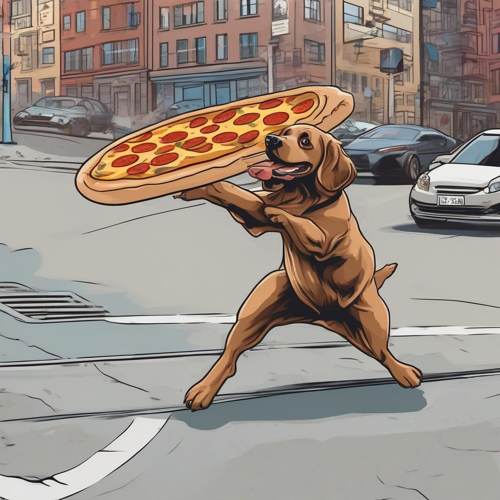

In [20]:
prompt = "A cocker dog trying catch a flying pizza in style of comic book, at a street corner."

# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "parameters": {
    "num_inference_steps" : 25,
    "negative_prompt" : "disfigured, ugly, deformed"
    } 
  }
)

# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))

### Delete model and endpoint

To clean up, we can delete the model and endpoint.

In [48]:
predictor.delete_model()
predictor.delete_endpoint()